# Introduction
This homework is programming based, where you must use Python to explore the fitting and gener-
alization of regression models via simulation.

Suppose that $X$ and $Y$ are both real valued random variables, where $X$ takes value in $(0; 1)$ and $Y$
depends on X according to
$$Y = cos(2\pi X) + Z ......(1)$$
where $Z$ is a zero mean Gaussian random variable with variance $\sigma^2$ , and $Z$ is independent of $X$. But assume
that you do not know this dependency of $Y$ on $X$ and that you only observe a sample of $N (X; Y )$ pairs.
Based on the observed sample, you must learn a polynomial regression model and examine the fitting and
generalization capability of your model in relation to the model complexity and sample size.

Below detailed instructions are given to guide you through this exercise. These instructions only serve as
a guideline, which your implementation need not to rigorously follow. You must use Python to write your
code. It is fine and encouraged, but NOT compulsory, if you use a Python package that does automatic
differentiation.1 But you must implement manually gradient-based optimization. That is, the
use of the package is only for you to compute the required gradients and you must manually
code up the update of model parameters. You need to submit the following deliverables.
* All Python code
* A concise report explaining your findings.

# A
Write a function ***getData*** that generates a dataset $\{f(x_i; y_i) : i = 1, 2...N\}$ of $N (X, Y)$ pairs for a
given value of $N$ and $\sigma^2$. The $X$ values are drawn uniformly at random from $(0, 1)$ and the corresponding
$Y$ values are generated according to $(1)$.

The dataset created by ***getData*** will then be used to fit your regression models. Of course, in the design
of your regression model, you should assume no knowledge on how the dataset is generated.

The regression models we consider will be exclusively polynomial models, namely, predicts Y from X
according to
$$Y = a_0 + a_1X + a_2X^2 + ... + a_dX^d$$
where d is the polynomial degree and $a_i$'s are coefficients to be estimated.

In [1]:
import random
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def getData(N, sigma=0.01, draw=True):
  # x = torch.FloatTensor(n,).uniform_(0, 1)
  x = torch.rand(N)
  z = torch.normal(0, sigma, size=(N,))
  f = torch.cos(2*np.pi*x)
  y = f + z

  if draw:
    fig, ax = plt.subplots()
    # sns.lineplot(x=x, y=f, color='red', label='f(x)', ax=ax)
    sns.scatterplot(x=x, y=y, color='blue', label="training data", ax=ax)
    plt.title("getData")
  return x, y


torch.Size([200]) torch.Size([200])


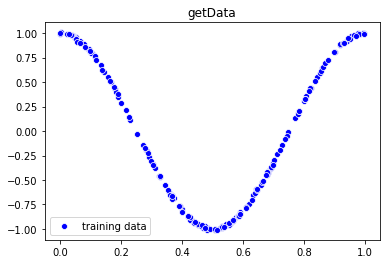

In [3]:
# Test getData()
x, y = getData(200, 0.01)
print(x.size(), y.size())

# B
Write a function ***getMSE*** which computes the mean square error (MSE) for a given dataset fitted to a specified polynomial.

In [3]:
# x should be a (d+1)×batch_size matrix, y is a 1×batch_size matrix, ad is the 1×(d+1) coefficient
def getMSE(x, y, ad):
  # x is already extended in polynomial way
  y_ex = torch.matmul(ad, x)
  return torch.mean(torch.square(y - y_ex))

# C
Write a function ***fitData*** that estimates the polynomial coefficients by fitting a given dataset to a degree-d polynomial. The function returns the following:
1. The estimated polynomial coefficients. The estimation of the coefficients should be based on GD\SGD\mini-batched SGD.
2. The MSE of the dataset fitted to the estimated polynomial. This MSE will be denoted by $E_{in}$.
3. $E_{out}$. To obtain this value, your function needs to generate a separate large testing dataset (say,
containing 1000 or 2000 data points) using getData and under the same setting of $\sigma^2$ and compute
the MSE of the testing dataset fitted to the estimated polynomial.
The computation of Ein and Eout calls **getMSE**.

In [4]:
def fitData(x, y, d=20, batch_size=10, draw=True, n_epochs=500):
  ad = torch.rand(d+1)
  ad.requires_grad = True
  l = 0.01 # Learning rate
  loss = []
  Ein = []

  # Get Ein
  for epoch in range(n_epochs):

      # Returns a random permutation of integers from 0 to n - 1.
      permutation = torch.randperm(x.size()[0])

      for i in range(0,x.size()[0], batch_size):
          # optimizer.zero_grad()

          indices = permutation[i:i+batch_size]
          xi, yi = x[indices], y[indices]
          
          x_poly = torch.zeros(d+1, batch_size)
          for i in range(d+1):
            x_poly[i] = xi ** i

          # in case you wanted a semi-full example
          loss.append(getMSE(x_poly, yi, ad).item())
          temp = 2 * (yi - torch.matmul(ad, x_poly)) * x_poly
          temp = torch.sum(temp, dim=1)
          ad_new = ad + l * temp / batch_size
          ad = ad_new
      # optimizer.step()

      Ein.append(sum(loss)/len(loss))
      loss = []
  
  if draw:
    # plot the figure
    fig, ax = plt.subplots()
    sns.lineplot(x=range(len(Ein)), y=Ein, color='blue', label = 'Ein', ax=ax)
    plt.title("MSE epoch")
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
  
  #Get Eout
  test_size = 1000
  x_out, y_out = getData(test_size, draw=False)
  x_out_poly = torch.zeros(d+1, test_size)
  for i in range(d+1):
    x_out_poly[i] = x_out ** i
  Eout = getMSE(x_out_poly, y_out, ad).item()
  
  return ad, Ein[-1], Eout

Ein is:  0.024507883936166763
Eout is: 0.025868888944387436


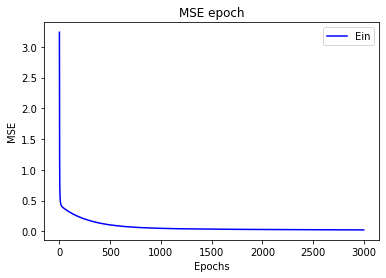

In [11]:
# Test fitData()
x, y = getData(N=1000, sigma=0.01, draw=False)
ad, Ein, Eout = fitData(x, y, d=20, batch_size=100, n_epochs=3000)
print("Ein is: ", Ein)
print("Eout is:", Eout)

# D
Write a function ***experiment*** that takes as input the size N of training dataset, the degree d of the
model polynomial and noise variance $\sigma^2$), and does the following. For the given values of N,d and $\sigma^2$, it
loops over M trials (M not smaller than 20; say, 50 would be a decent number), where each trial is defined
as generating a training dataset of size N and noise variance $\sigma^2$ (by calling ***getData***) and then fitting the
data to a polynomial of degree d (by calling ***fitData***). The computed $E_{in}$ and $E_{out}$ are respectively averaged
over the M trials, which are denoted by $E_{in}$ and $E_{out}$. The obtained M polynomials over the M trials are
also averaged. The function then generates another large dataset with noise variance $\sigma^2$ and computes the
average MSE for the dataset fitted to the average polynomial. This MSE will be denoted by $E_{bias}$. The
function outputs $E_{in}$, $E_{out}$ and $E_{bias}$. These three values are the metrics that you will examine.

In [37]:
def experiment(N, sigma, d, batch_size=10, n_epochs=500, wd=None):
  M = 30
  Ein = []
  Eout = []
  ad = torch.zeros([M, d+1])
  
  # if no wd is given, then the experiment is done without weight decay
  if not wd:
    # To get the Ein and Eout and ad
    for i in range(M):
      x, y = getData(N, sigma, False)
      ad_t, Ein_t, Eout_t = fitData(x, y, d, batch_size=batch_size, draw=False, n_epochs=n_epochs)
      Ein.append(Ein_t)
      Eout.append(Eout_t)
      ad[i] = ad_t
    
    Ein = torch.FloatTensor(Ein)
    Eout = torch.FloatTensor(Eout)
    
    # Get E_bias
    ad_ave = torch.mean(ad, axis=0)
    x_bias, y_bias = getData(N, sigma, False)
    x_poly = torch.zeros(d+1, N)
    for i in range(d+1):
      x_poly[i] = x_bias ** i
    E_bias = getMSE(x_poly, y_bias, ad_ave).item()
  
  else:
    # To get the Ein and Eout and ad
    for i in range(M):
      x, y = getData(N, sigma, False)
      ad_t, Ein_t, Eout_t = fitData_wd(x, y, d, batch_size=batch_size,
                          draw=False, n_epochs=n_epochs,
                           wd=wd)
      Ein.append(Ein_t)
      Eout.append(Eout_t)
      ad[i] = ad_t
    
    Ein = torch.FloatTensor(Ein)
    Eout = torch.FloatTensor(Eout)

    # Get E_bias
    ad_ave = torch.mean(ad, axis=0)
    x_bias, y_bias = getData(N, sigma, False)
    x_poly = torch.zeros(d+1, N)
    for i in range(d+1):
      x_poly[i] = x_bias ** i
    E_bias = getMSE_wd(x_poly, y_bias, ad_ave, wd=wd).item()

  return torch.mean(Ein).item(), torch.mean(Eout).item(), E_bias

In [17]:
# Test experiment
Ein, Eout, Ebias = experiment(200, 0.01, 20, batch_size=20, n_epochs=1000)
print(Ein, Eout, Ebias)

0.05068271979689598 0.05154363065958023 0.052007194608449936


# E
Run experiment for all combinations of $N$, $d$, and $\sigma_2$, with $N\in\{2, 5, 10, 20, 50, 100, 200\}$, $d\in\{0, 1, 2, ..., 20\}$, $\sigma\in\{0.01, 0.1, 1\}$. Organize the results in plots and comment on what you observe regarding fitting and generalization of your models, in relation to model complexity (d), sample size (N), and
noise level ($\sigma$). Note:

* Plots under comparison should display the same Y-range.
* You do not need to plot all the results. Rather, you should carefully design the ways you plot your
results so as to be the most illustrative and to fully reflect you understanding.

In [13]:
# N = [2, 5, 10, 20, 50, 100, 200]
# d = [i for i in range(20)]
# sigma = [0.01, 0.1, 1]

In [18]:
# Try to see the relativity between model complexity and over-fitting
d = 30
Ein = []
Eout = []
for i in range(d+1):
  Ein_t, Eout_t, Ebias = experiment(100, 0.01, i, batch_size=20, n_epochs=800)
  Ein.append(Ein_t)
  Eout.append(Eout_t)

Text(0, 0.5, 'MSE')

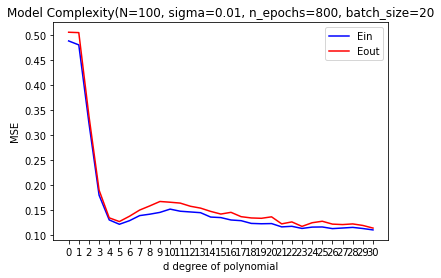

In [21]:
fig, ax = plt.subplots()

sns.lineplot(x=d, y=Ein, color='blue', label = 'Ein', ax=ax)
sns.lineplot(x=d, y=Eout, color='red', label = 'Eout', ax=ax)
plt.xticks(d)
plt.title("Model Complexity(N=100, sigma=0.01, n_epochs=800, batch_size=20")
plt.xlabel("d degree of polynomial")
plt.ylabel("MSE")

In [ ]:
# Different N in simple model and complex model
N = [2, 6, 12, 20, 50, 100, 200]
batch_size = [1, 2, 3, 5, 10, 10, 20]
d1 = 10
d2 = 30
Ein1 = []
Ein2 = []
Eout1 = []
Eout2 = []
for i in range(len(N)):
  Ein_t1, Eout_t1, Ebias1 = experiment(N[i], 0.01, d1, batch_size=batch_size[i], n_epochs=1000)
  Ein_t2, Eout_t2, Ebias2 = experiment(N[i], 0.01, d2, batch_size=batch_size[i], n_epochs=1000)
  Ein1.append(Ein_t1)
  Eout1.append(Eout_t1)
  Ein2.append(Ein_t2)
  Eout2.append(Eout_t2)

Text(0, 0.5, 'MSE')

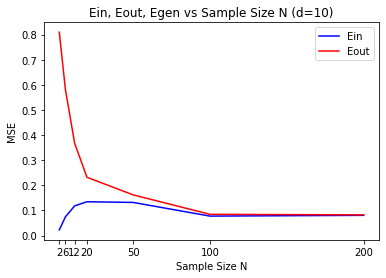

In [9]:
# plot the result
fig, ax = plt.subplots()
sns.lineplot(x=N, y=Ein1, color='blue', label = 'Ein', ax=ax)
sns.lineplot(x=N, y=Eout1, color='red', label = 'Eout', ax=ax)
plt.xticks(N)
plt.title("Ein, Eout, Egen vs Sample Size N (d=10)")
plt.xlabel("Sample Size N")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

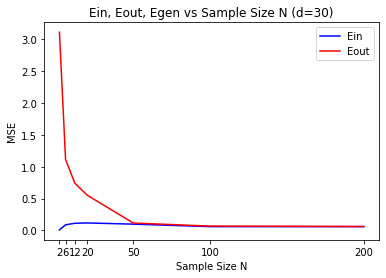

In [10]:
# plot the result
fig, ax = plt.subplots()
sns.lineplot(x=N, y=Ein2, color='blue', label = 'Ein', ax=ax)
sns.lineplot(x=N, y=Eout2, color='red', label = 'Eout', ax=ax)
plt.xticks(N)
plt.title("Ein, Eout, Egen vs Sample Size N (d=30)")
plt.xlabel("Sample Size N")
plt.ylabel("MSE")

In [31]:
# Change sigma
sigma = [0.01, 0.1, 0.5, 1, 2]
d = 30
Ein = []
Eout = []
for i in sigma:
  Ein_t, Eout_t, Ebias = experiment(100, i, d, batch_size=4, n_epochs=800)
  Ein.append(Ein_t)
  Eout.append(Eout_t)

Text(0, 0.5, 'MSE')

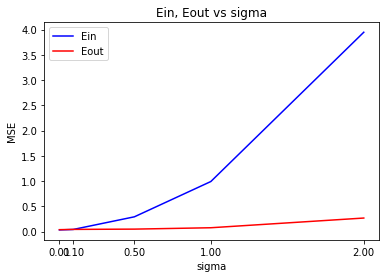

In [32]:
# plot the result
fig, ax = plt.subplots()
sns.lineplot(x=sigma, y=Ein, color='blue', label = 'Ein', ax=ax)
sns.lineplot(x=sigma, y=Eout, color='red', label = 'Eout', ax=ax)
plt.xticks(sigma)
plt.title("Ein, Eout vs sigma")
plt.xlabel("sigma")
plt.ylabel("MSE")

# F
Revise your code to include weight decay regularization, and redo (E). Plot the results and comment
on what you observe.

In [33]:
def getMSE_wd(x, y, ad, wd=0.01):
  y_ex = torch.matmul(ad, x)
  MSE = torch.mean(torch.square(y - y_ex))
  add = wd * torch.sum(ad ** 2)
  return MSE + add

In [34]:
def fitData_wd(x, y, d=20, batch_size=10, draw=True, n_epochs=500, wd=0.01):
  ad = torch.rand(d+1)
  ad.requires_grad = True
  l = 0.01 # Learning rate
  loss = []
  Ein = []

  # Get Ein
  for epoch in range(n_epochs):

      # Returns a random permutation of integers from 0 to n - 1.
      permutation = torch.randperm(x.size()[0])

      for i in range(0,x.size()[0], batch_size):
          # optimizer.zero_grad()

          indices = permutation[i:i+batch_size]
          xi, yi = x[indices], y[indices]
          
          x_poly = torch.zeros(d+1, batch_size)
          for i in range(d+1):
            x_poly[i] = xi ** i

          # in case you wanted a semi-full example
          loss.append(getMSE_wd(x_poly, yi, ad, wd=wd).item())
          temp = 2 * (yi - torch.matmul(ad, x_poly)) * x_poly
          temp = torch.sum(temp, dim=1)
          ad_new = (1 - wd) * ad + l * temp / batch_size
          ad = ad_new
      # optimizer.step()

      Ein.append(sum(loss)/len(loss))
      loss = []
  
  if draw:
    # plot the figure
    fig, ax = plt.subplots()
    sns.lineplot(x=range(len(Ein)), y=Ein, color='blue', label = 'Ein', ax=ax)
    plt.title("MSE epoch")
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
  
  #Get Eout
  test_size = 1000
  x_out, y_out = getData(test_size, draw=False)
  x_out_poly = torch.zeros(d+1, test_size)
  for i in range(d+1):
    x_out_poly[i] = x_out ** i
  Eout = getMSE_wd(x_out_poly, y_out, ad, wd=wd).item()
  
  return ad, Ein[-1], Eout

In [50]:
# Test weight decay
# Try to see the relativity between model complexity and over-fitting
d = 30
Ein = []
Eout = []
for i in range(d+1):
  Ein_t, Eout_t, Ebias = experiment(12, 0.01, i, batch_size=4, n_epochs=2000, wd=0.01)
  Ein.append(Ein_t)
  Eout.append(Eout_t)

Text(0, 0.5, 'MSE')

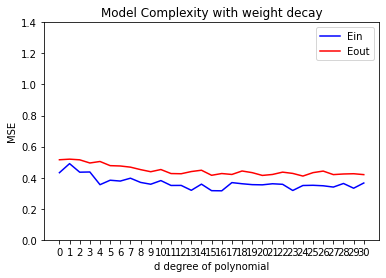

In [52]:
# Plot the result
fig, ax = plt.subplots()
d = [i for i in range(d+1)]
sns.lineplot(x=d, y=Ein, color='blue', label = 'Ein', ax=ax)
sns.lineplot(x=d, y=Eout, color='red', label = 'Eout', ax=ax)
plt.xticks(d)
axes = plt.gca()
axes.set_ylim([0,1.4])
plt.title("Model Complexity with weight decay")
plt.xlabel("d degree of polynomial")
plt.ylabel("MSE")